### Libraries and setup

In [1]:
import pandas as pd
import json
import datetime as dt
from pytz import timezone
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdate
import numpy as np
from haversine import haversine, Unit
import folium

In [2]:
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18

sao_paulo = [-23.5489, -46.6388]

### Trips

In [3]:
trips = pd.read_csv('../../../yellow/saida.csv')
print(len(trips), 'trips')
trips.head()

427026 trips


tripid  \
0  75b1aba38fc22016e5770e8b5c5e517efee06ed23544d1...   
1  daadf046a3b54be5dfa3885ae8e91b416d301b8c2cdd6e...   
2  0dce3489467eb12a7f6df6e9dd219fae235414192cfd7d...   
3  e41936fda2bdf2baefef3ae2d007405768d2dfb1a69d74...   
4  d79a96b92300855c6756872fe342c9cf6da9d0f87b1c78...   

                                              bikeid  \
0  3c03eee3949f1f26daae3903d18b68a4c4e8eed59a3729...   
1  3c03eee3949f1f26daae3903d18b68a4c4e8eed59a3729...   
2  3c03eee3949f1f26daae3903d18b68a4c4e8eed59a3729...   
3  3c03eee3949f1f26daae3903d18b68a4c4e8eed59a3729...   
4  3c03eee3949f1f26daae3903d18b68a4c4e8eed59a3729...   

                        timestamps                               lats  \
0                 [1535376181.586]                [-23.5929358843934]   
1  [1535379421.701,1535379421.733]  [-23.594451904296875,-23.5944525]   
2                 [1535382141.792]                      [-23.5901707]   
3                 [1535383270.083]                [-23.5807991400581]   
4                 [1535385729.579]                [-23.5815868750092]   

                              longs  
0               [-46.6806704085755]  
1  [-46.68463134765625,-46.6846324]  
2                     [-46.6865773]  
3               [-46.6839137860077]  
4               [-46.6855699552242]

* Previously calculated data

In [4]:
calculated = pd.read_csv('../../../yellow/calculated-variables.csv', parse_dates=['start_time'])
trips = trips.merge(calculated, on='tripid', how='left')

In [5]:
def dist_chart(series, title, unit, thousands=False):
    def numbers_in_thousands(num,pos):
        num = num/1000
        num = int(num)
        return '{}'.format(num)

    plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax.xaxis.grid(False)
    if thousands:
        formatter = tkr.FuncFormatter(numbers_in_thousands)
        ax.yaxis.set_major_formatter(formatter)
    plt.hist(bins=500, x=series)
    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel('Trips' + (' (in thousands)' if thousands else ''))
    plt.show()

In [13]:
def plot_trip(trip, plot_points=True):
    fmap = folium.Map(sao_paulo, 
                      zoom_start=12, 
                      control_scale = True,
                      tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
                      attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="https://carto.com/attributions">CARTO</a>')

    lats = json.loads(trip.lats)
    longs = json.loads(trip.longs)
    points = zip(lats, longs)
    ant = next(points)
    for p in points:
        folium.PolyLine(locations=[ant, p], color='blue', weight=3).add_to(fmap)
        ant = p
    if plot_points:
        points = zip(lats, longs)
        ant = next(points)
        for p in points:
            folium.CircleMarker(p, radius=1, color='red').add_to(fmap)
            ant = p

    display(fmap)

In [31]:
#filter trips using interquartile range
def set_iqr(df,column,lower_bound=0.25,upper_bound=0.75,whisker_width=1.5):
    q_lower = df[column].quantile(lower_bound)
    q_upper = df[column].quantile(upper_bound)
    iqr = q_upper - q_lower
    low_limit = q_lower - whisker_width * iqr
    up_limit = q_upper + whisker_width * iqr
    return df[(df[column]>=low_limit)&(df[column]<=up_limit)]
    

### GPS Takes

* Number of GPS takes
  * 2 takes are needed for flow analysis
  * 3+ takes are needed for path analysis

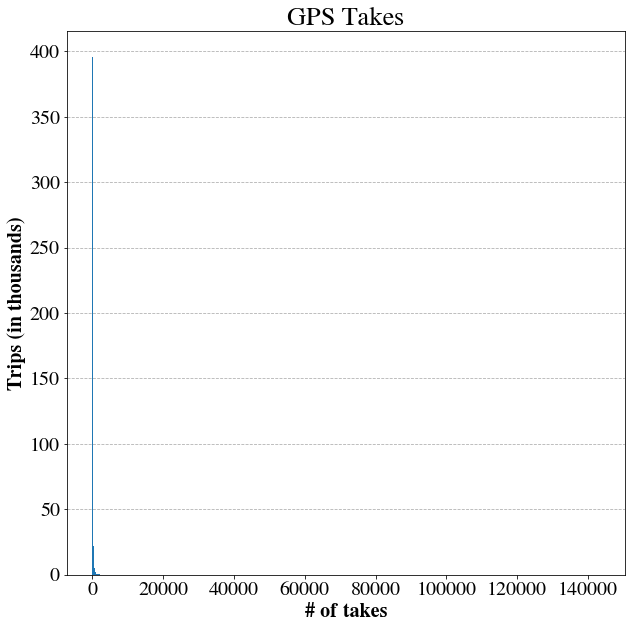

In [14]:
dist_chart(trips.num_of_takes, 'GPS Takes', '# of takes', thousands=True)

#### Trips x takes

In [15]:
print(len(trips[trips.num_of_takes == 0]), 'trips without takes')
print(len(trips[trips.num_of_takes == 1]), 'trips with only 1 take')
print(len(trips[trips.num_of_takes == 2]), 'trips with only 2 takes')
print(len(trips[trips.num_of_takes > 2]), 'trips with more than 2 takes')
print(len(trips[trips.num_of_takes > 5000]), 'trips with more than 5000 takes')

0 trips without takes
40171 trips with only 1 take
34393 trips with only 2 takes
352462 trips with more than 2 takes
154 trips with more than 5000 takes


In [16]:
len(trips[trips.num_of_takes == 1]) / len(trips)

0.0940715553619686

In [17]:
len(trips[trips.num_of_takes == 2]) / len(trips)

0.08054076332588649

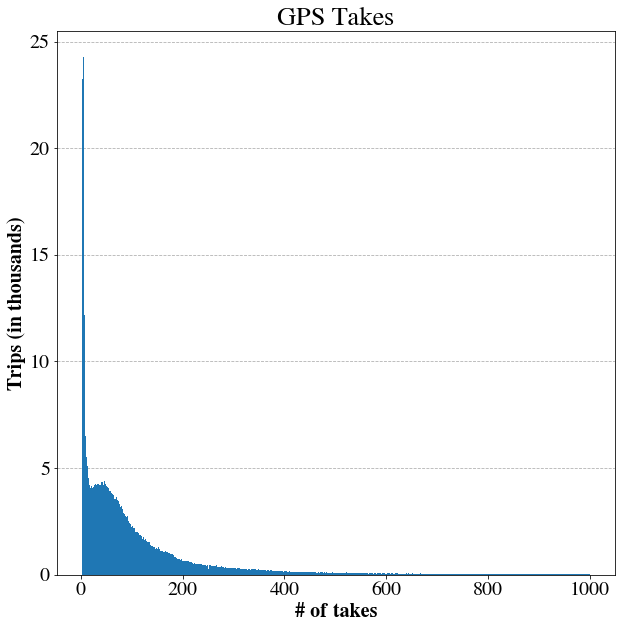

In [18]:
dist_chart(trips.num_of_takes[(trips.num_of_takes > 2) & (trips.num_of_takes < 1000)], 
           'GPS Takes', '# of takes', thousands=True)

### Number of takes

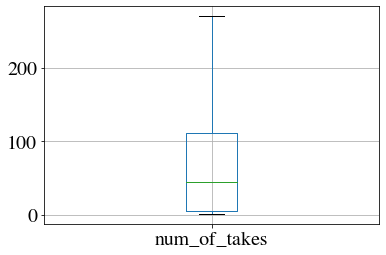

In [19]:
trips.boxplot(column='num_of_takes',showfliers=False)

In [20]:
# few trips witih more than 500 takes
len(trips[trips.num_of_takes > 500])/len(trips)

0.028103675186054246

In [21]:
# a lot of trips with 1 take
len(trips[trips.num_of_takes < 2])/len(trips)

0.0940715553619686

In [22]:
trips.num_of_takes.describe()

count    427026.000000
mean        100.147855
std         397.737998
min           1.000000
25%           5.000000
50%          44.000000
75%         111.000000
max      143259.000000
Name: num_of_takes, dtype: float64

#### filtering trips by number of takes using IQR

In [32]:
trips_by_number_of_takes = set_iqr(trips,'num_of_takes')

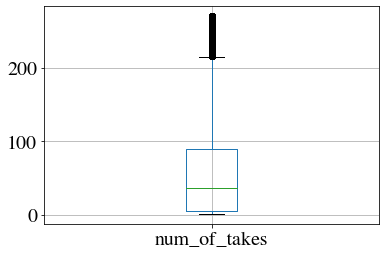

In [33]:
trips_by_number_of_takes.boxplot(column='num_of_takes')

In [34]:
trips_by_number_of_takes.num_of_takes.describe()

count    392769.000000
mean         57.163249
std          63.523898
min           1.000000
25%           5.000000
50%          36.000000
75%          89.000000
max         270.000000
Name: num_of_takes, dtype: float64

#### Mean distance of takes (in meters)
##### The values below show that GPS takes each 25 meters are enough to have a good coverage. A block has around 100 meters so in a straight line the GPS takes can cover all blocks in a trip. Also, turns during trips are covered by taking the position each 25 meters.

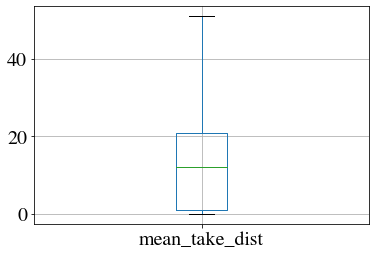

In [23]:
trips.boxplot(column='mean_take_dist',showfliers=False)

In [28]:
# a few trips with mean greater than 100 meters per take
len(trips[trips.mean_take_dist > 100])/len(trips)

0.025340377400907672

In [29]:
# a lot of trips with mean lower than 1 meter per take
len(trips[trips.mean_take_dist < 1])/len(trips)

0.25431004201149343

In [30]:
trips.mean_take_dist.describe()

count    4.270260e+05
mean     6.180613e+01
std      7.881103e+03
min      0.000000e+00
25%      8.742986e-01
50%      1.216703e+01
75%      2.093667e+01
max      2.839804e+06
Name: mean_take_dist, dtype: float64

#### filtering trips by mean distance of takes using IQR

In [35]:
trips_by_mean_take_distance = set_iqr(trips,'mean_take_dist')

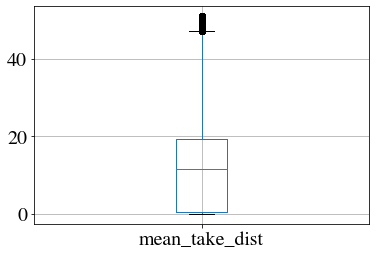

In [36]:
trips_by_mean_take_distance.boxplot(column='mean_take_dist')

In [37]:
trips_by_mean_take_distance.mean_take_dist.describe()

count    407212.000000
mean         12.209374
std          11.197630
min           0.000000
25%           0.567242
50%          11.447006
75%          19.178476
max          51.030022
Name: mean_take_dist, dtype: float64

In [38]:
trips_by_mean_take_distance.num_of_takes.describe()

count    407212.000000
mean        100.748170
std         404.212908
min           1.000000
25%           5.000000
50%          46.000000
75%         112.000000
max      143259.000000
Name: num_of_takes, dtype: float64

#### Combining both criteria (num_of_takes + mean_take_dist)

In [39]:
trips_by_take = set_iqr(trips_by_mean_take_distance,'num_of_takes')

In [40]:
trips_by_take.num_of_takes.describe()

count    375051.000000
mean         58.218437
std          64.031073
min           1.000000
25%           4.000000
50%          38.000000
75%          91.000000
max         272.000000
Name: num_of_takes, dtype: float64

### GPS takes per month

In [77]:
trip_time_series = trips[['num_of_takes','start_time']]
trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['start_time']), inplace=True)

In [ ]:
#average of takes per month
trips_day_average = trip_time_series['num_of_takes'].groupby(pd.Grouper(freq='D')).sum()/trip_time_series['num_of_takes'].groupby(pd.Grouper(freq='D')).count()
trips_per_month = trips_day_average.groupby(pd.Grouper(freq='MS')).agg(mean='mean',std='std')

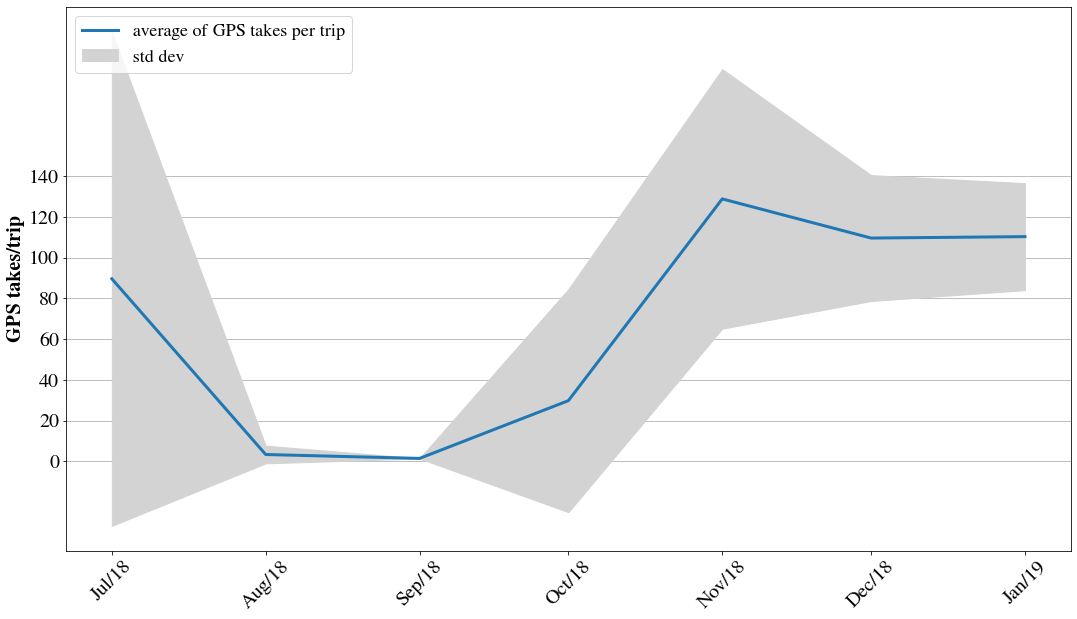

In [130]:
#trips_per_month.plot()
dateFmt = mdate.DateFormatter('%b/%y')
ax_day_avg_trips = plt.axes()
ax_day_avg_trips.set_axisbelow(True)
ax_day_avg_trips.xaxis.grid(False)
ax_day_avg_trips.yaxis.grid(True)
ax_day_avg_trips.plot(trips_per_month['mean'], label='average of GPS takes per trip', linewidth=3)
ax_day_avg_trips.figure.set_size_inches(18,10)
ax_day_avg_trips.xaxis.set_major_formatter(dateFmt)
ax_day_avg_trips.xaxis.set_minor_locator(mdate.MonthLocator())

plt.ylabel('GPS takes/trip')

plt.xticks(rotation=45)
plt.yticks(np.arange(0,151,step=20))
plt.fill_between(trips_per_month.index,trips_per_month['mean']-trips_per_month['std'],
                 trips_per_month['mean']+trips_per_month['std'],color='lightgray',label='std dev')
plt.legend(loc='upper left')

#plt.savefig('charts/GPS-Takes-Per-Trip.pdf', format='pdf', dpi=200)
plt.draw()

#### Mean take distance per month

In [131]:
take_dist_time_series = trips[['mean_take_dist','start_time']]
take_dist_time_series.set_index(pd.DatetimeIndex(take_dist_time_series['start_time']), inplace=True)

In [134]:
#average of takes per month
take_dist_day_avg = take_dist_time_series['mean_take_dist'].groupby(pd.Grouper(freq='D')).sum()/take_dist_time_series['mean_take_dist'].groupby(pd.Grouper(freq='D')).count()
take_dist_per_month = take_dist_day_avg.groupby(pd.Grouper(freq='MS')).agg(mean='mean',std='std')

In [138]:
#take_dist_day_avg.head()
take_dist_per_month.head(10)

mean          std
start_time                         
2018-07-01   10.824544    13.244308
2018-08-01  673.353445  3735.470632
2018-09-01    0.220036     0.381572
2018-10-01   90.222345   256.228422
2018-11-01   65.553913   160.556141
2018-12-01   50.326522    78.099692
2019-01-01   59.729130    91.632350

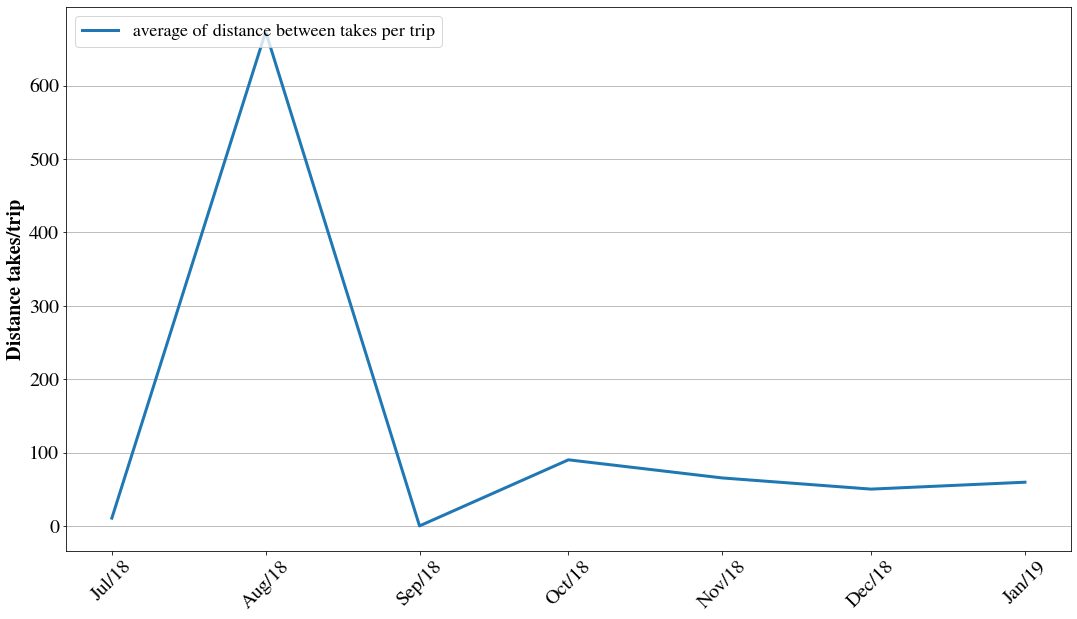

In [140]:
#trips_per_month.plot()
dateFmt = mdate.DateFormatter('%b/%y')
ax_day_avg_trips = plt.axes()
ax_day_avg_trips.set_axisbelow(True)
ax_day_avg_trips.xaxis.grid(False)
ax_day_avg_trips.yaxis.grid(True)
ax_day_avg_trips.plot(take_dist_per_month['mean'], label='average of distance between takes per trip', linewidth=3)
ax_day_avg_trips.figure.set_size_inches(18,10)
ax_day_avg_trips.xaxis.set_major_formatter(dateFmt)
ax_day_avg_trips.xaxis.set_minor_locator(mdate.MonthLocator())

plt.ylabel('Distance takes/trip')

plt.xticks(rotation=45)
plt.yticks(np.arange(0,700,step=100))
#plt.fill_between(take_dist_per_month.index,take_dist_per_month['mean']-take_dist_per_month['std'],
#                 take_dist_per_month['mean']+take_dist_per_month['std'],color='lightgray',label='std dev')
plt.legend(loc='upper right')

#plt.savefig('charts/GPS-Takes-Per-Trip.pdf', format='pdf', dpi=200)
plt.draw()

### Viewing trips

In [155]:
#day_trip = trips[trips['start_time']<='2018-07-25']
day_trip = trips[(trips['start_time']<'2018-08-31')&(trips['start_time']>='2018-08-01')]
day_trip = day_trip[day_trip['num_of_takes']>10]

In [156]:
len(day_trip)

63

In [161]:
idx = day_trip.index[61]
print(day_trip.loc[idx])
plot_trip(day_trip.loc[idx])

tripid            9251d544ee86c3049bca70f63567c6273c4b7cd0dd1ee4...
bikeid            d210bfa53044ee3300cd8a8b6e4aa2a8bdd827cc8cee3c...
timestamps        [1533656037.201,1533656039.657,1533656045.578,...
lats              [-23.560001373291016,-23.5600018,-23.5599946,-...
longs             [-46.699859619140625,-46.6998613,-46.6998889,-...
start_time                               2018-08-07 12:33:57.201000
num_of_takes                                                     73
mean_intervals                                              9.33685
durations                                                   11.3598
distance                                                    525.969
mean_take_dist                                              7.20505
speed                                                       2.77804
limit_levels                                                      0
Name: 419711, dtype: object


* There are some trips out of streets...i sthat related to specific bikes (bad GPS in those bikes)
* example bikeid 8abc152dbfa2f10313c46c8475c104f12e7761f5ac1c7e46806650a6

In [158]:
day_trip.loc[day_trip.index[1]].bikeid

'8abc152dbfa2f10313c46c8475c104f12e7761f5ac1c7e46806650a6'

In [ ]:
* and about trips